# Classification with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from vbranch.callbacks import classification_acc
from vbranch.applications.fcn import FCN
from vbranch.applications.cnn import CNN
from vbranch.losses import softmax_cross_entropy_with_logits

from vbranch.utils import TFSessionGrow, restore_sess
from vbranch.utils.training import get_data, bag_samples, get_data_iterator
from vbranch.utils.generic import get_path, save_results

Using TensorFlow backend.


In [3]:
MODEL_ID = 1
ARCHITECTURE = 'cnn'
DATASET = 'cifar10'
NUM_CLASSES = 10
NUM_FEATURES = None
SAMPLES_PER_CLASS = None
BAGGING_SAMPLES = 1.
TRAIN_FRAC = 1.

BATCH_SIZE = 128
EPOCHS = 50
STEPS_PER_EPOCH = 100

## Data

In [4]:
(X_train, y_train), (X_test, y_test) = get_data(DATASET, ARCHITECTURE, NUM_CLASSES,
                                                NUM_FEATURES, SAMPLES_PER_CLASS, 
                                                train_frac=TRAIN_FRAC, preprocess=True)
x_shape = (None,) + X_train.shape[1:]
y_shape = (None, NUM_CLASSES)

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [6]:
print(X_train.min(), X_train.max())

-1.0 1.0


## Training

In [7]:
def path(n_branches, shared_frac):
    return get_path(DATASET, ARCHITECTURE, 'sensitivity-2', vb=True, 
                    B=n_branches, S=shared_frac)

In [8]:
def build_model(n_branches, shared_frac, name='model'):
    inputs, labels, train_init_op, test_init_op = get_data_iterator(x_shape, y_shape, 
                                                                    batch_size=BATCH_SIZE, 
                                                                    n=n_branches, 
                                                                    share_xy=BAGGING_SAMPLES == 0)
#     with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
#         if ARCHITECTURE == 'fcn':
#             layer_spec = [(512, shared_frac), NUM_CLASSES]
#         elif ARCHITECTURE == 'fcn2':
#             layer_spec = [(512, shared_frac), 512, NUM_CLASSES]
#         elif ARCHITECTURE == 'fcn3':
#             layer_spec = [(512, shared_frac), 512, 512, NUM_CLASSES]
#         elif ARCHITECTURE == 'fcn2A':
#             layer_spec = [(512, shared_frac), (512, shared_frac), (NUM_CLASSES, shared_frac)]
#         elif ARCHITECTURE == 'fcn3A':
#             layer_spec = [(512, shared_frac), (512, shared_frac), 
#                           (512, shared_frac), (NUM_CLASSES, shared_frac)]
#         else:
#             raise ValueError('invalid model')
            
#         model = FCN(inputs, *layer_spec, name=name, shared_frac=1)

    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        if ARCHITECTURE == 'cnn':
            layers = [32, 64, 128]
        elif ARCHITECTURE == 'cnnx':
            layers = [(32, shared_frac), (64, 1.0), (128, 1.0)]
        else:
            raise ValueError('invalid model')
        model = CNN(inputs, NUM_CLASSES, *layers, name=name, shared_frac=shared_frac)

        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        model.compile(optimizer, softmax_cross_entropy_with_logits(), 
                      train_init_op, test_init_op, labels=labels, 
                      callbacks={'acc':classification_acc(n_branches)})

    return model

In [9]:
def train(n_branches, shared_frac, model_id=1):
    dirpath = path(n_branches, shared_frac)
    print(dirpath)
    
    tf.reset_default_graph()
    model = build_model(n_branches, shared_frac)
    model.summary()
    
    # Bagging
    if BAGGING_SAMPLES > 0:
        x_train_list, y_train_list = bag_samples(X_train, y_train, n_branches, 
                                                 max_samples=BAGGING_SAMPLES)

    if n_branches == 1 or BAGGING_SAMPLES == 0:
        train_dict = {'x:0': X_train, 'y:0': y_train, 'batch_size:0': BATCH_SIZE}
    else:
        train_dict = {'x:0': X_train, 'y:0': y_train}
        for i in range(n_branches):
            train_dict['vb{}_x:0'.format(i+1)] = x_train_list[i]
            train_dict['vb{}_y:0'.format(i+1)] = y_train_list[i]
        train_dict['batch_size:0'] = BATCH_SIZE

    val_dict = {'x:0': X_test, 'y:0': y_test, 'batch_size:0': len(X_test)}

    model_path = os.path.join('models', dirpath, 'model_{}'.format(model_id))
    os.system('mkdir -p ' + model_path)
    history = model.fit(EPOCHS, STEPS_PER_EPOCH, train_dict=train_dict,
                        val_dict=val_dict, log_path=model_path)
    save_results(history, dirpath, 'train_{}.csv'.format(model_id))
    
    return history

In [10]:
for n_branches in range(2, 5):
    for shared_frac in [0., 0.25, 0.5, 0.75, 1.]:
        for t in range(4):
            train(n_branches, shared_frac, model_id=t+1)
# history = train(n_branches=1, shared_frac=None)

W0803 01:09:49.422678 140268897367808 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/utils/training.py:134: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 01:09:49.476947 140268897367808 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/utils/training.py:156: The name tf.data.Iterator is deprecated. Please use tf.compat.v1.data.Iterator instead.

W0803 01:09:49.482336 140268897367808 deprecation.py:323] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py:348: Iterator.output_types (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
W0803 01:09:49.482869 140268897367808 deprecation.py:323] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py:349: Iterator.output_shapes (from tensorflow.pyt

sensitivity-2/vb-cifar10-cnn/B2/S0.00


W0803 01:09:49.894680 140268897367808 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/layers/core.py:83: The name tf.nn.xw_plus_b is deprecated. Please use tf.compat.v1.nn.xw_plus_b instead.

W0803 01:09:49.990088 140268897367808 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/engine/training.py:127: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.



i   Layer name                      Output shape        Num param  Inbound            
--------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                    
--------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                    
--------------------------------------------------------------------------------------
0   conv2d_1_1 (Conv2D)             [] [None,32,32,32]  1792       input              
                                    [] [None,32,32,32]                                
--------------------------------------------------------------------------------------
1   bn_1_1 (BatchNormalization)     [] [None,32,32,32]  128        conv2d_1_1         
                                    [] [None,32,32,32]                                
-------------------------------------------

100/100 - 8s - loss_1: 0.8447 - loss_2: 0.8554 - acc_ensemble: 0.7480 - acc_1: 0.7230 - acc_2: 0.7130 - val_loss_1: 0.8366 - val_loss_2: 0.8494 - val_acc_ensemble: 0.7306 - val_acc_1: 0.7019 - val_acc_2: 0.6968
Epoch 7/50
100/100 - 8s - loss_1: 0.7780 - loss_2: 0.7940 - acc_ensemble: 0.7830 - acc_1: 0.7550 - acc_2: 0.7360 - val_loss_1: 0.7951 - val_loss_2: 0.7856 - val_acc_ensemble: 0.7465 - val_acc_1: 0.7180 - val_acc_2: 0.7246
Epoch 8/50
100/100 - 8s - loss_1: 0.7108 - loss_2: 0.7076 - acc_ensemble: 0.7840 - acc_1: 0.7640 - acc_2: 0.7530 - val_loss_1: 0.7536 - val_loss_2: 0.7676 - val_acc_ensemble: 0.7580 - val_acc_1: 0.7332 - val_acc_2: 0.7298
Epoch 9/50
100/100 - 8s - loss_1: 0.6815 - loss_2: 0.7061 - acc_ensemble: 0.8010 - acc_1: 0.7850 - acc_2: 0.7660 - val_loss_1: 0.7119 - val_loss_2: 0.7208 - val_acc_ensemble: 0.7775 - val_acc_1: 0.7507 - val_acc_2: 0.7456
Epoch 10/50
100/100 - 8s - loss_1: 0.6478 - loss_2: 0.6543 - acc_ensemble: 0.8280 - acc_1: 0.7950 - acc_2: 0.7810 - val_los

Epoch 43/50
100/100 - 8s - loss_1: 0.1710 - loss_2: 0.1452 - acc_ensemble: 0.9740 - acc_1: 0.9390 - acc_2: 0.9390 - val_loss_1: 0.5881 - val_loss_2: 0.5728 - val_acc_ensemble: 0.8601 - val_acc_1: 0.8220 - val_acc_2: 0.8294
Epoch 44/50
100/100 - 8s - loss_1: 0.1453 - loss_2: 0.1708 - acc_ensemble: 0.9710 - acc_1: 0.9430 - acc_2: 0.9430 - val_loss_1: 0.5652 - val_loss_2: 0.5486 - val_acc_ensemble: 0.8602 - val_acc_1: 0.8334 - val_acc_2: 0.8338
Epoch 45/50
100/100 - 8s - loss_1: 0.1224 - loss_2: 0.1520 - acc_ensemble: 0.9700 - acc_1: 0.9440 - acc_2: 0.9480 - val_loss_1: 0.5766 - val_loss_2: 0.5610 - val_acc_ensemble: 0.8642 - val_acc_1: 0.8368 - val_acc_2: 0.8348
Epoch 46/50
100/100 - 8s - loss_1: 0.1517 - loss_2: 0.1252 - acc_ensemble: 0.9760 - acc_1: 0.9570 - acc_2: 0.9600 - val_loss_1: 0.5693 - val_loss_2: 0.5533 - val_acc_ensemble: 0.8622 - val_acc_1: 0.8319 - val_acc_2: 0.8416
Epoch 47/50
100/100 - 8s - loss_1: 0.1405 - loss_2: 0.1246 - acc_ensemble: 0.9780 - acc_1: 0.9460 - acc_2: 0

Epoch 1/50
100/100 - 9s - loss_1: 1.6568 - loss_2: 1.6231 - acc_ensemble: 0.5420 - acc_1: 0.4850 - acc_2: 0.5070 - val_loss_1: 1.4354 - val_loss_2: 1.3576 - val_acc_ensemble: 0.5152 - val_acc_1: 0.4688 - val_acc_2: 0.5047
Epoch 2/50
100/100 - 8s - loss_1: 1.3373 - loss_2: 1.2693 - acc_ensemble: 0.6270 - acc_1: 0.5860 - acc_2: 0.6120 - val_loss_1: 1.1800 - val_loss_2: 1.1276 - val_acc_ensemble: 0.6053 - val_acc_1: 0.5771 - val_acc_2: 0.5876
Epoch 3/50
100/100 - 8s - loss_1: 1.1344 - loss_2: 1.1075 - acc_ensemble: 0.6740 - acc_1: 0.6440 - acc_2: 0.6300 - val_loss_1: 1.0538 - val_loss_2: 1.0380 - val_acc_ensemble: 0.6578 - val_acc_1: 0.6204 - val_acc_2: 0.6325
Epoch 4/50
100/100 - 8s - loss_1: 1.0063 - loss_2: 0.9696 - acc_ensemble: 0.7040 - acc_1: 0.6780 - acc_2: 0.6560 - val_loss_1: 0.9968 - val_loss_2: 0.9500 - val_acc_ensemble: 0.6796 - val_acc_1: 0.6424 - val_acc_2: 0.6616
Epoch 5/50
100/100 - 8s - loss_1: 0.9194 - loss_2: 0.9051 - acc_ensemble: 0.7270 - acc_1: 0.6850 - acc_2: 0.6880

Epoch 38/50
100/100 - 8s - loss_1: 0.2310 - loss_2: 0.1962 - acc_ensemble: 0.9580 - acc_1: 0.9460 - acc_2: 0.9420 - val_loss_1: 0.5382 - val_loss_2: 0.5332 - val_acc_ensemble: 0.8586 - val_acc_1: 0.8355 - val_acc_2: 0.8352
Epoch 39/50
100/100 - 8s - loss_1: 0.1718 - loss_2: 0.1710 - acc_ensemble: 0.9730 - acc_1: 0.9530 - acc_2: 0.9420 - val_loss_1: 0.5584 - val_loss_2: 0.5347 - val_acc_ensemble: 0.8624 - val_acc_1: 0.8325 - val_acc_2: 0.8355
Epoch 40/50
100/100 - 8s - loss_1: 0.1657 - loss_2: 0.1531 - acc_ensemble: 0.9750 - acc_1: 0.9510 - acc_2: 0.9470 - val_loss_1: 0.5402 - val_loss_2: 0.5446 - val_acc_ensemble: 0.8620 - val_acc_1: 0.8367 - val_acc_2: 0.8362
Epoch 41/50
100/100 - 8s - loss_1: 0.1405 - loss_2: 0.1555 - acc_ensemble: 0.9710 - acc_1: 0.9490 - acc_2: 0.9410 - val_loss_1: 0.5605 - val_loss_2: 0.5559 - val_acc_ensemble: 0.8616 - val_acc_1: 0.8345 - val_acc_2: 0.8309
Epoch 42/50
100/100 - 8s - loss_1: 0.1653 - loss_2: 0.1880 - acc_ensemble: 0.9710 - acc_1: 0.9470 - acc_2: 0

Epoch 1/50
100/100 - 9s - loss_1: 1.6720 - loss_2: 1.6556 - acc_ensemble: 0.5250 - acc_1: 0.4680 - acc_2: 0.4940 - val_loss_1: 1.4415 - val_loss_2: 1.3944 - val_acc_ensemble: 0.5156 - val_acc_1: 0.4611 - val_acc_2: 0.4960
Epoch 2/50
100/100 - 8s - loss_1: 1.3324 - loss_2: 1.2990 - acc_ensemble: 0.5780 - acc_1: 0.5440 - acc_2: 0.5700 - val_loss_1: 1.2200 - val_loss_2: 1.2052 - val_acc_ensemble: 0.5829 - val_acc_1: 0.5549 - val_acc_2: 0.5615
Epoch 3/50
100/100 - 8s - loss_1: 1.1267 - loss_2: 1.1358 - acc_ensemble: 0.6560 - acc_1: 0.6200 - acc_2: 0.6320 - val_loss_1: 1.0825 - val_loss_2: 1.0693 - val_acc_ensemble: 0.6470 - val_acc_1: 0.6065 - val_acc_2: 0.6117
Epoch 4/50
100/100 - 8s - loss_1: 1.0362 - loss_2: 0.9966 - acc_ensemble: 0.6910 - acc_1: 0.6620 - acc_2: 0.6430 - val_loss_1: 0.9932 - val_loss_2: 0.9995 - val_acc_ensemble: 0.6774 - val_acc_1: 0.6398 - val_acc_2: 0.6402
Epoch 5/50
100/100 - 8s - loss_1: 0.9216 - loss_2: 0.9160 - acc_ensemble: 0.7270 - acc_1: 0.6800 - acc_2: 0.6940

Epoch 38/50
100/100 - 8s - loss_1: 0.2133 - loss_2: 0.1953 - acc_ensemble: 0.9670 - acc_1: 0.9300 - acc_2: 0.9440 - val_loss_1: 0.5312 - val_loss_2: 0.5413 - val_acc_ensemble: 0.8591 - val_acc_1: 0.8304 - val_acc_2: 0.8325
Epoch 39/50
100/100 - 8s - loss_1: 0.1947 - loss_2: 0.1780 - acc_ensemble: 0.9640 - acc_1: 0.9240 - acc_2: 0.9330 - val_loss_1: 0.5283 - val_loss_2: 0.5627 - val_acc_ensemble: 0.8616 - val_acc_1: 0.8352 - val_acc_2: 0.8300
Epoch 40/50
100/100 - 8s - loss_1: 0.1986 - loss_2: 0.1753 - acc_ensemble: 0.9710 - acc_1: 0.9390 - acc_2: 0.9290 - val_loss_1: 0.5314 - val_loss_2: 0.5694 - val_acc_ensemble: 0.8633 - val_acc_1: 0.8351 - val_acc_2: 0.8307
Epoch 41/50
100/100 - 8s - loss_1: 0.1612 - loss_2: 0.1546 - acc_ensemble: 0.9750 - acc_1: 0.9480 - acc_2: 0.9480 - val_loss_1: 0.5315 - val_loss_2: 0.5494 - val_acc_ensemble: 0.8619 - val_acc_1: 0.8350 - val_acc_2: 0.8350
Epoch 42/50
100/100 - 8s - loss_1: 0.1560 - loss_2: 0.1713 - acc_ensemble: 0.9720 - acc_1: 0.9570 - acc_2: 0

Epoch 1/50
100/100 - 9s - loss_1: 1.6562 - loss_2: 1.6376 - acc_ensemble: 0.5500 - acc_1: 0.5180 - acc_2: 0.5260 - val_loss_1: 1.3693 - val_loss_2: 1.3639 - val_acc_ensemble: 0.5307 - val_acc_1: 0.5015 - val_acc_2: 0.5003
Epoch 2/50
100/100 - 8s - loss_1: 1.2771 - loss_2: 1.2634 - acc_ensemble: 0.6070 - acc_1: 0.5670 - acc_2: 0.5770 - val_loss_1: 1.1764 - val_loss_2: 1.1632 - val_acc_ensemble: 0.6050 - val_acc_1: 0.5683 - val_acc_2: 0.5761
Epoch 3/50
100/100 - 8s - loss_1: 1.1097 - loss_2: 1.1110 - acc_ensemble: 0.6520 - acc_1: 0.6180 - acc_2: 0.6650 - val_loss_1: 1.0256 - val_loss_2: 1.0004 - val_acc_ensemble: 0.6607 - val_acc_1: 0.6263 - val_acc_2: 0.6435
Epoch 4/50
100/100 - 8s - loss_1: 0.9852 - loss_2: 1.0059 - acc_ensemble: 0.7070 - acc_1: 0.6780 - acc_2: 0.6760 - val_loss_1: 0.9861 - val_loss_2: 0.9898 - val_acc_ensemble: 0.6754 - val_acc_1: 0.6444 - val_acc_2: 0.6455
Epoch 5/50
100/100 - 8s - loss_1: 0.9195 - loss_2: 0.9234 - acc_ensemble: 0.7260 - acc_1: 0.7030 - acc_2: 0.6860

Epoch 38/50
100/100 - 8s - loss_1: 0.1901 - loss_2: 0.1995 - acc_ensemble: 0.9710 - acc_1: 0.9480 - acc_2: 0.9250 - val_loss_1: 0.5338 - val_loss_2: 0.5494 - val_acc_ensemble: 0.8600 - val_acc_1: 0.8340 - val_acc_2: 0.8268
Epoch 39/50
100/100 - 8s - loss_1: 0.1655 - loss_2: 0.1702 - acc_ensemble: 0.9680 - acc_1: 0.9300 - acc_2: 0.9360 - val_loss_1: 0.5718 - val_loss_2: 0.5560 - val_acc_ensemble: 0.8592 - val_acc_1: 0.8206 - val_acc_2: 0.8347
Epoch 40/50
100/100 - 8s - loss_1: 0.1709 - loss_2: 0.1666 - acc_ensemble: 0.9710 - acc_1: 0.9450 - acc_2: 0.9340 - val_loss_1: 0.5361 - val_loss_2: 0.5675 - val_acc_ensemble: 0.8599 - val_acc_1: 0.8374 - val_acc_2: 0.8276
Epoch 41/50
100/100 - 8s - loss_1: 0.1672 - loss_2: 0.1886 - acc_ensemble: 0.9750 - acc_1: 0.9440 - acc_2: 0.9400 - val_loss_1: 0.5479 - val_loss_2: 0.5510 - val_acc_ensemble: 0.8626 - val_acc_1: 0.8337 - val_acc_2: 0.8295
Epoch 42/50
100/100 - 8s - loss_1: 0.1848 - loss_2: 0.1670 - acc_ensemble: 0.9770 - acc_1: 0.9430 - acc_2: 0

Epoch 1/50
100/100 - 20s - loss_1: 1.6436 - loss_2: 1.6646 - acc_ensemble: 0.5320 - acc_1: 0.4950 - acc_2: 0.5290 - val_loss_1: 1.3825 - val_loss_2: 1.3539 - val_acc_ensemble: 0.5239 - val_acc_1: 0.4876 - val_acc_2: 0.5064
Epoch 2/50
100/100 - 11s - loss_1: 1.2567 - loss_2: 1.2920 - acc_ensemble: 0.6120 - acc_1: 0.5800 - acc_2: 0.5910 - val_loss_1: 1.1679 - val_loss_2: 1.1964 - val_acc_ensemble: 0.5998 - val_acc_1: 0.5718 - val_acc_2: 0.5677
Epoch 3/50
100/100 - 11s - loss_1: 1.0967 - loss_2: 1.1159 - acc_ensemble: 0.6730 - acc_1: 0.6410 - acc_2: 0.6570 - val_loss_1: 1.0416 - val_loss_2: 1.0404 - val_acc_ensemble: 0.6618 - val_acc_1: 0.6322 - val_acc_2: 0.6303
Epoch 4/50
100/100 - 11s - loss_1: 0.9726 - loss_2: 1.0032 - acc_ensemble: 0.6990 - acc_1: 0.6800 - acc_2: 0.6740 - val_loss_1: 0.9822 - val_loss_2: 0.9730 - val_acc_ensemble: 0.6801 - val_acc_1: 0.6558 - val_acc_2: 0.6558
Epoch 5/50
100/100 - 11s - loss_1: 0.9076 - loss_2: 0.9126 - acc_ensemble: 0.7190 - acc_1: 0.6850 - acc_2: 0

Epoch 38/50
100/100 - 11s - loss_1: 0.1773 - loss_2: 0.1951 - acc_ensemble: 0.9690 - acc_1: 0.9390 - acc_2: 0.9490 - val_loss_1: 0.6469 - val_loss_2: 0.6729 - val_acc_ensemble: 0.8399 - val_acc_1: 0.8084 - val_acc_2: 0.8042
Epoch 39/50
100/100 - 11s - loss_1: 0.1797 - loss_2: 0.1569 - acc_ensemble: 0.9790 - acc_1: 0.9420 - acc_2: 0.9660 - val_loss_1: 0.6883 - val_loss_2: 0.6673 - val_acc_ensemble: 0.8417 - val_acc_1: 0.7973 - val_acc_2: 0.8090
Epoch 40/50
100/100 - 11s - loss_1: 0.1520 - loss_2: 0.1422 - acc_ensemble: 0.9830 - acc_1: 0.9580 - acc_2: 0.9690 - val_loss_1: 0.6877 - val_loss_2: 0.6702 - val_acc_ensemble: 0.8383 - val_acc_1: 0.7988 - val_acc_2: 0.8091
Epoch 41/50
100/100 - 11s - loss_1: 0.1213 - loss_2: 0.1468 - acc_ensemble: 0.9860 - acc_1: 0.9610 - acc_2: 0.9640 - val_loss_1: 0.6981 - val_loss_2: 0.6900 - val_acc_ensemble: 0.8419 - val_acc_1: 0.8077 - val_acc_2: 0.8014
Epoch 42/50
100/100 - 11s - loss_1: 0.1598 - loss_2: 0.1116 - acc_ensemble: 0.9860 - acc_1: 0.9490 - acc

Epoch 1/50
100/100 - 16s - loss_1: 1.7017 - loss_2: 1.6612 - acc_ensemble: 0.5230 - acc_1: 0.4820 - acc_2: 0.4760 - val_loss_1: 1.4214 - val_loss_2: 1.4015 - val_acc_ensemble: 0.5166 - val_acc_1: 0.4845 - val_acc_2: 0.4829
Epoch 2/50
100/100 - 11s - loss_1: 1.2973 - loss_2: 1.3128 - acc_ensemble: 0.6220 - acc_1: 0.5620 - acc_2: 0.5780 - val_loss_1: 1.2662 - val_loss_2: 1.2141 - val_acc_ensemble: 0.5924 - val_acc_1: 0.5355 - val_acc_2: 0.5581
Epoch 3/50
100/100 - 11s - loss_1: 1.1497 - loss_2: 1.1364 - acc_ensemble: 0.6840 - acc_1: 0.6240 - acc_2: 0.6550 - val_loss_1: 1.1093 - val_loss_2: 1.0738 - val_acc_ensemble: 0.6402 - val_acc_1: 0.6071 - val_acc_2: 0.6145
Epoch 4/50
100/100 - 11s - loss_1: 1.0210 - loss_2: 1.0072 - acc_ensemble: 0.7030 - acc_1: 0.6620 - acc_2: 0.6830 - val_loss_1: 1.0124 - val_loss_2: 1.0145 - val_acc_ensemble: 0.6731 - val_acc_1: 0.6405 - val_acc_2: 0.6360
Epoch 5/50
100/100 - 11s - loss_1: 0.9543 - loss_2: 0.9057 - acc_ensemble: 0.7350 - acc_1: 0.6870 - acc_2: 0

Epoch 38/50
100/100 - 11s - loss_1: 0.1848 - loss_2: 0.1670 - acc_ensemble: 0.9650 - acc_1: 0.9370 - acc_2: 0.9380 - val_loss_1: 0.6919 - val_loss_2: 0.6661 - val_acc_ensemble: 0.8329 - val_acc_1: 0.7982 - val_acc_2: 0.8065
Epoch 39/50
100/100 - 11s - loss_1: 0.1723 - loss_2: 0.1730 - acc_ensemble: 0.9680 - acc_1: 0.9470 - acc_2: 0.9390 - val_loss_1: 0.6936 - val_loss_2: 0.6791 - val_acc_ensemble: 0.8334 - val_acc_1: 0.7997 - val_acc_2: 0.8016
Epoch 40/50
100/100 - 11s - loss_1: 0.1631 - loss_2: 0.1560 - acc_ensemble: 0.9710 - acc_1: 0.9500 - acc_2: 0.9410 - val_loss_1: 0.6890 - val_loss_2: 0.6959 - val_acc_ensemble: 0.8330 - val_acc_1: 0.7982 - val_acc_2: 0.8026
Epoch 41/50
100/100 - 11s - loss_1: 0.1512 - loss_2: 0.1437 - acc_ensemble: 0.9840 - acc_1: 0.9510 - acc_2: 0.9530 - val_loss_1: 0.7017 - val_loss_2: 0.6897 - val_acc_ensemble: 0.8354 - val_acc_1: 0.7999 - val_acc_2: 0.8026
Epoch 42/50
100/100 - 11s - loss_1: 0.1321 - loss_2: 0.1431 - acc_ensemble: 0.9800 - acc_1: 0.9510 - acc

Epoch 1/50
100/100 - 16s - loss_1: 1.7072 - loss_2: 1.7008 - acc_ensemble: 0.5170 - acc_1: 0.4830 - acc_2: 0.4890 - val_loss_1: 1.4139 - val_loss_2: 1.4183 - val_acc_ensemble: 0.5088 - val_acc_1: 0.4807 - val_acc_2: 0.4768
Epoch 2/50
100/100 - 11s - loss_1: 1.3332 - loss_2: 1.2998 - acc_ensemble: 0.6060 - acc_1: 0.5720 - acc_2: 0.5810 - val_loss_1: 1.2102 - val_loss_2: 1.2169 - val_acc_ensemble: 0.5901 - val_acc_1: 0.5673 - val_acc_2: 0.5593
Epoch 3/50
100/100 - 11s - loss_1: 1.1297 - loss_2: 1.1378 - acc_ensemble: 0.6490 - acc_1: 0.6100 - acc_2: 0.6310 - val_loss_1: 1.1095 - val_loss_2: 1.0885 - val_acc_ensemble: 0.6308 - val_acc_1: 0.5945 - val_acc_2: 0.6106
Epoch 4/50
100/100 - 11s - loss_1: 1.0205 - loss_2: 1.0276 - acc_ensemble: 0.7030 - acc_1: 0.6490 - acc_2: 0.6890 - val_loss_1: 1.0113 - val_loss_2: 0.9787 - val_acc_ensemble: 0.6723 - val_acc_1: 0.6347 - val_acc_2: 0.6480
Epoch 5/50
100/100 - 11s - loss_1: 0.9201 - loss_2: 0.9327 - acc_ensemble: 0.7220 - acc_1: 0.6790 - acc_2: 0

Epoch 38/50
100/100 - 11s - loss_1: 0.1677 - loss_2: 0.1624 - acc_ensemble: 0.9670 - acc_1: 0.9370 - acc_2: 0.9430 - val_loss_1: 0.6815 - val_loss_2: 0.6788 - val_acc_ensemble: 0.8365 - val_acc_1: 0.8025 - val_acc_2: 0.8045
Epoch 39/50
100/100 - 11s - loss_1: 0.1833 - loss_2: 0.1710 - acc_ensemble: 0.9700 - acc_1: 0.9470 - acc_2: 0.9430 - val_loss_1: 0.6892 - val_loss_2: 0.6729 - val_acc_ensemble: 0.8364 - val_acc_1: 0.8037 - val_acc_2: 0.8040
Epoch 40/50
100/100 - 11s - loss_1: 0.1550 - loss_2: 0.1695 - acc_ensemble: 0.9780 - acc_1: 0.9510 - acc_2: 0.9400 - val_loss_1: 0.6804 - val_loss_2: 0.6967 - val_acc_ensemble: 0.8374 - val_acc_1: 0.8094 - val_acc_2: 0.7998
Epoch 41/50
100/100 - 11s - loss_1: 0.1741 - loss_2: 0.1614 - acc_ensemble: 0.9700 - acc_1: 0.9360 - acc_2: 0.9340 - val_loss_1: 0.7058 - val_loss_2: 0.6854 - val_acc_ensemble: 0.8384 - val_acc_1: 0.8001 - val_acc_2: 0.8021
Epoch 42/50
100/100 - 11s - loss_1: 0.1771 - loss_2: 0.1455 - acc_ensemble: 0.9750 - acc_1: 0.9490 - acc

Epoch 1/50
100/100 - 16s - loss_1: 1.6671 - loss_2: 1.6946 - acc_ensemble: 0.5360 - acc_1: 0.5060 - acc_2: 0.5050 - val_loss_1: 1.3614 - val_loss_2: 1.4166 - val_acc_ensemble: 0.5098 - val_acc_1: 0.4941 - val_acc_2: 0.4768
Epoch 2/50
100/100 - 11s - loss_1: 1.2500 - loss_2: 1.3221 - acc_ensemble: 0.6290 - acc_1: 0.5930 - acc_2: 0.5780 - val_loss_1: 1.1713 - val_loss_2: 1.1916 - val_acc_ensemble: 0.6115 - val_acc_1: 0.5745 - val_acc_2: 0.5775
Epoch 3/50
100/100 - 11s - loss_1: 1.0886 - loss_2: 1.1472 - acc_ensemble: 0.6540 - acc_1: 0.6350 - acc_2: 0.6110 - val_loss_1: 1.0562 - val_loss_2: 1.1228 - val_acc_ensemble: 0.6544 - val_acc_1: 0.6255 - val_acc_2: 0.5926
Epoch 4/50
100/100 - 11s - loss_1: 0.9894 - loss_2: 1.0144 - acc_ensemble: 0.7130 - acc_1: 0.6430 - acc_2: 0.6930 - val_loss_1: 1.0130 - val_loss_2: 0.9806 - val_acc_ensemble: 0.6798 - val_acc_1: 0.6392 - val_acc_2: 0.6509
Epoch 5/50
100/100 - 11s - loss_1: 0.9145 - loss_2: 0.9367 - acc_ensemble: 0.7360 - acc_1: 0.6800 - acc_2: 0

Epoch 38/50
100/100 - 11s - loss_1: 0.1765 - loss_2: 0.1567 - acc_ensemble: 0.9740 - acc_1: 0.9470 - acc_2: 0.9370 - val_loss_1: 0.6418 - val_loss_2: 0.6882 - val_acc_ensemble: 0.8402 - val_acc_1: 0.8126 - val_acc_2: 0.8017
Epoch 39/50
100/100 - 11s - loss_1: 0.1547 - loss_2: 0.1807 - acc_ensemble: 0.9680 - acc_1: 0.9470 - acc_2: 0.9300 - val_loss_1: 0.6557 - val_loss_2: 0.6958 - val_acc_ensemble: 0.8372 - val_acc_1: 0.8085 - val_acc_2: 0.8012
Epoch 40/50
100/100 - 11s - loss_1: 0.1647 - loss_2: 0.1616 - acc_ensemble: 0.9830 - acc_1: 0.9450 - acc_2: 0.9470 - val_loss_1: 0.6703 - val_loss_2: 0.6945 - val_acc_ensemble: 0.8383 - val_acc_1: 0.8105 - val_acc_2: 0.8014
Epoch 41/50
100/100 - 11s - loss_1: 0.1458 - loss_2: 0.1550 - acc_ensemble: 0.9710 - acc_1: 0.9460 - acc_2: 0.9470 - val_loss_1: 0.6668 - val_loss_2: 0.7043 - val_acc_ensemble: 0.8386 - val_acc_1: 0.8085 - val_acc_2: 0.7995
Epoch 42/50
100/100 - 11s - loss_1: 0.1490 - loss_2: 0.1467 - acc_ensemble: 0.9770 - acc_1: 0.9460 - acc

Epoch 1/50
100/100 - 17s - loss_1: 1.7071 - loss_2: 1.6415 - acc_ensemble: 0.5340 - acc_1: 0.4870 - acc_2: 0.5260 - val_loss_1: 1.4338 - val_loss_2: 1.3615 - val_acc_ensemble: 0.5148 - val_acc_1: 0.4690 - val_acc_2: 0.4982
Epoch 2/50
100/100 - 11s - loss_1: 1.3259 - loss_2: 1.2802 - acc_ensemble: 0.6130 - acc_1: 0.5750 - acc_2: 0.5720 - val_loss_1: 1.2113 - val_loss_2: 1.2256 - val_acc_ensemble: 0.5960 - val_acc_1: 0.5675 - val_acc_2: 0.5567
Epoch 3/50
100/100 - 11s - loss_1: 1.1307 - loss_2: 1.1054 - acc_ensemble: 0.6850 - acc_1: 0.6530 - acc_2: 0.6430 - val_loss_1: 1.0495 - val_loss_2: 1.0794 - val_acc_ensemble: 0.6502 - val_acc_1: 0.6262 - val_acc_2: 0.6144
Epoch 4/50
100/100 - 11s - loss_1: 1.0174 - loss_2: 1.0104 - acc_ensemble: 0.7100 - acc_1: 0.6820 - acc_2: 0.6870 - val_loss_1: 0.9908 - val_loss_2: 0.9694 - val_acc_ensemble: 0.6705 - val_acc_1: 0.6428 - val_acc_2: 0.6527
Epoch 5/50
100/100 - 11s - loss_1: 0.9241 - loss_2: 0.9182 - acc_ensemble: 0.7250 - acc_1: 0.6780 - acc_2: 0

Epoch 38/50
100/100 - 11s - loss_1: 0.1749 - loss_2: 0.1801 - acc_ensemble: 0.9760 - acc_1: 0.9400 - acc_2: 0.9450 - val_loss_1: 0.6713 - val_loss_2: 0.6774 - val_acc_ensemble: 0.8377 - val_acc_1: 0.8029 - val_acc_2: 0.8046
Epoch 39/50
100/100 - 11s - loss_1: 0.1816 - loss_2: 0.1770 - acc_ensemble: 0.9760 - acc_1: 0.9360 - acc_2: 0.9530 - val_loss_1: 0.6870 - val_loss_2: 0.6845 - val_acc_ensemble: 0.8339 - val_acc_1: 0.7964 - val_acc_2: 0.8002
Epoch 40/50
100/100 - 11s - loss_1: 0.1855 - loss_2: 0.1670 - acc_ensemble: 0.9780 - acc_1: 0.9400 - acc_2: 0.9530 - val_loss_1: 0.6831 - val_loss_2: 0.6789 - val_acc_ensemble: 0.8369 - val_acc_1: 0.8043 - val_acc_2: 0.8046
Epoch 41/50
100/100 - 11s - loss_1: 0.1552 - loss_2: 0.1632 - acc_ensemble: 0.9730 - acc_1: 0.9450 - acc_2: 0.9430 - val_loss_1: 0.7183 - val_loss_2: 0.7127 - val_acc_ensemble: 0.8296 - val_acc_1: 0.7933 - val_acc_2: 0.7954
Epoch 42/50
100/100 - 11s - loss_1: 0.1474 - loss_2: 0.1555 - acc_ensemble: 0.9830 - acc_1: 0.9480 - acc

Epoch 1/50
100/100 - 16s - loss_1: 1.6534 - loss_2: 1.6840 - acc_ensemble: 0.5200 - acc_1: 0.5080 - acc_2: 0.4850 - val_loss_1: 1.4098 - val_loss_2: 1.4476 - val_acc_ensemble: 0.5040 - val_acc_1: 0.4827 - val_acc_2: 0.4707
Epoch 2/50
100/100 - 11s - loss_1: 1.3076 - loss_2: 1.2995 - acc_ensemble: 0.6250 - acc_1: 0.6050 - acc_2: 0.5970 - val_loss_1: 1.1968 - val_loss_2: 1.2341 - val_acc_ensemble: 0.5924 - val_acc_1: 0.5659 - val_acc_2: 0.5569
Epoch 3/50
100/100 - 11s - loss_1: 1.1271 - loss_2: 1.1508 - acc_ensemble: 0.6600 - acc_1: 0.6320 - acc_2: 0.6330 - val_loss_1: 1.0859 - val_loss_2: 1.1192 - val_acc_ensemble: 0.6359 - val_acc_1: 0.6123 - val_acc_2: 0.5990
Epoch 4/50
100/100 - 11s - loss_1: 1.0018 - loss_2: 1.0298 - acc_ensemble: 0.7070 - acc_1: 0.6820 - acc_2: 0.6510 - val_loss_1: 1.0090 - val_loss_2: 1.0403 - val_acc_ensemble: 0.6667 - val_acc_1: 0.6420 - val_acc_2: 0.6298
Epoch 5/50
100/100 - 11s - loss_1: 0.9406 - loss_2: 0.9276 - acc_ensemble: 0.7350 - acc_1: 0.6960 - acc_2: 0

Epoch 38/50
100/100 - 11s - loss_1: 0.1868 - loss_2: 0.1766 - acc_ensemble: 0.9630 - acc_1: 0.9400 - acc_2: 0.9410 - val_loss_1: 0.6976 - val_loss_2: 0.6813 - val_acc_ensemble: 0.8307 - val_acc_1: 0.7964 - val_acc_2: 0.7911
Epoch 39/50
100/100 - 11s - loss_1: 0.1610 - loss_2: 0.1757 - acc_ensemble: 0.9740 - acc_1: 0.9480 - acc_2: 0.9450 - val_loss_1: 0.6965 - val_loss_2: 0.6731 - val_acc_ensemble: 0.8334 - val_acc_1: 0.7970 - val_acc_2: 0.7960
Epoch 40/50
100/100 - 11s - loss_1: 0.1685 - loss_2: 0.1698 - acc_ensemble: 0.9790 - acc_1: 0.9450 - acc_2: 0.9410 - val_loss_1: 0.7359 - val_loss_2: 0.6850 - val_acc_ensemble: 0.8273 - val_acc_1: 0.7920 - val_acc_2: 0.7972
Epoch 41/50
100/100 - 11s - loss_1: 0.1451 - loss_2: 0.1664 - acc_ensemble: 0.9740 - acc_1: 0.9440 - acc_2: 0.9450 - val_loss_1: 0.7105 - val_loss_2: 0.7167 - val_acc_ensemble: 0.8296 - val_acc_1: 0.8008 - val_acc_2: 0.7926
Epoch 42/50
100/100 - 11s - loss_1: 0.1594 - loss_2: 0.1699 - acc_ensemble: 0.9830 - acc_1: 0.9500 - acc

Epoch 1/50
100/100 - 16s - loss_1: 1.6494 - loss_2: 1.7368 - acc_ensemble: 0.5270 - acc_1: 0.4950 - acc_2: 0.5020 - val_loss_1: 1.4033 - val_loss_2: 1.4244 - val_acc_ensemble: 0.5117 - val_acc_1: 0.4839 - val_acc_2: 0.4774
Epoch 2/50
100/100 - 11s - loss_1: 1.2717 - loss_2: 1.3268 - acc_ensemble: 0.6070 - acc_1: 0.5820 - acc_2: 0.5830 - val_loss_1: 1.1908 - val_loss_2: 1.2278 - val_acc_ensemble: 0.5928 - val_acc_1: 0.5663 - val_acc_2: 0.5575
Epoch 3/50
100/100 - 11s - loss_1: 1.1157 - loss_2: 1.1284 - acc_ensemble: 0.6390 - acc_1: 0.6270 - acc_2: 0.5940 - val_loss_1: 1.0867 - val_loss_2: 1.1349 - val_acc_ensemble: 0.6266 - val_acc_1: 0.6112 - val_acc_2: 0.5865
Epoch 4/50
100/100 - 11s - loss_1: 0.9890 - loss_2: 1.0184 - acc_ensemble: 0.7020 - acc_1: 0.6650 - acc_2: 0.6460 - val_loss_1: 0.9893 - val_loss_2: 1.0167 - val_acc_ensemble: 0.6734 - val_acc_1: 0.6449 - val_acc_2: 0.6355
Epoch 5/50
100/100 - 11s - loss_1: 0.9088 - loss_2: 0.9463 - acc_ensemble: 0.7370 - acc_1: 0.7050 - acc_2: 0

Epoch 38/50
100/100 - 11s - loss_1: 0.2026 - loss_2: 0.1823 - acc_ensemble: 0.9660 - acc_1: 0.9450 - acc_2: 0.9450 - val_loss_1: 0.7018 - val_loss_2: 0.6833 - val_acc_ensemble: 0.8288 - val_acc_1: 0.7961 - val_acc_2: 0.7996
Epoch 39/50
100/100 - 11s - loss_1: 0.1389 - loss_2: 0.1622 - acc_ensemble: 0.9650 - acc_1: 0.9430 - acc_2: 0.9300 - val_loss_1: 0.7303 - val_loss_2: 0.7068 - val_acc_ensemble: 0.8288 - val_acc_1: 0.7914 - val_acc_2: 0.7940
Epoch 40/50
100/100 - 11s - loss_1: 0.1307 - loss_2: 0.1653 - acc_ensemble: 0.9770 - acc_1: 0.9600 - acc_2: 0.9370 - val_loss_1: 0.7100 - val_loss_2: 0.7234 - val_acc_ensemble: 0.8316 - val_acc_1: 0.7953 - val_acc_2: 0.7964
Epoch 41/50
100/100 - 11s - loss_1: 0.1446 - loss_2: 0.1559 - acc_ensemble: 0.9730 - acc_1: 0.9530 - acc_2: 0.9370 - val_loss_1: 0.7254 - val_loss_2: 0.7152 - val_acc_ensemble: 0.8308 - val_acc_1: 0.7969 - val_acc_2: 0.7966
Epoch 42/50
100/100 - 11s - loss_1: 0.1500 - loss_2: 0.1706 - acc_ensemble: 0.9700 - acc_1: 0.9580 - acc

Epoch 1/50
100/100 - 16s - loss_1: 1.6423 - loss_2: 1.6859 - acc_ensemble: 0.5180 - acc_1: 0.4990 - acc_2: 0.4750 - val_loss_1: 1.3899 - val_loss_2: 1.4302 - val_acc_ensemble: 0.5092 - val_acc_1: 0.4874 - val_acc_2: 0.4735
Epoch 2/50
100/100 - 11s - loss_1: 1.2999 - loss_2: 1.3326 - acc_ensemble: 0.6020 - acc_1: 0.5570 - acc_2: 0.5610 - val_loss_1: 1.2025 - val_loss_2: 1.2289 - val_acc_ensemble: 0.5965 - val_acc_1: 0.5612 - val_acc_2: 0.5600
Epoch 3/50
100/100 - 11s - loss_1: 1.1059 - loss_2: 1.1706 - acc_ensemble: 0.6670 - acc_1: 0.6190 - acc_2: 0.6340 - val_loss_1: 1.1002 - val_loss_2: 1.1273 - val_acc_ensemble: 0.6251 - val_acc_1: 0.6043 - val_acc_2: 0.5942
Epoch 4/50
100/100 - 11s - loss_1: 1.0241 - loss_2: 1.0343 - acc_ensemble: 0.6830 - acc_1: 0.6570 - acc_2: 0.6410 - val_loss_1: 1.0004 - val_loss_2: 1.0013 - val_acc_ensemble: 0.6723 - val_acc_1: 0.6411 - val_acc_2: 0.6469
Epoch 5/50
100/100 - 11s - loss_1: 0.9306 - loss_2: 0.9494 - acc_ensemble: 0.7240 - acc_1: 0.6970 - acc_2: 0

Epoch 38/50
100/100 - 11s - loss_1: 0.1836 - loss_2: 0.1742 - acc_ensemble: 0.9750 - acc_1: 0.9400 - acc_2: 0.9400 - val_loss_1: 0.6583 - val_loss_2: 0.6936 - val_acc_ensemble: 0.8345 - val_acc_1: 0.8044 - val_acc_2: 0.7977
Epoch 39/50
100/100 - 11s - loss_1: 0.1457 - loss_2: 0.1787 - acc_ensemble: 0.9810 - acc_1: 0.9530 - acc_2: 0.9460 - val_loss_1: 0.7065 - val_loss_2: 0.6788 - val_acc_ensemble: 0.8339 - val_acc_1: 0.7977 - val_acc_2: 0.8046
Epoch 40/50
100/100 - 11s - loss_1: 0.1699 - loss_2: 0.1670 - acc_ensemble: 0.9820 - acc_1: 0.9520 - acc_2: 0.9400 - val_loss_1: 0.6744 - val_loss_2: 0.7094 - val_acc_ensemble: 0.8353 - val_acc_1: 0.8022 - val_acc_2: 0.7998
Epoch 41/50
100/100 - 11s - loss_1: 0.1519 - loss_2: 0.1398 - acc_ensemble: 0.9780 - acc_1: 0.9370 - acc_2: 0.9370 - val_loss_1: 0.6935 - val_loss_2: 0.7171 - val_acc_ensemble: 0.8355 - val_acc_1: 0.8002 - val_acc_2: 0.8004
Epoch 42/50
100/100 - 11s - loss_1: 0.1688 - loss_2: 0.1578 - acc_ensemble: 0.9760 - acc_1: 0.9500 - acc

Epoch 1/50
100/100 - 16s - loss_1: 1.6512 - loss_2: 1.6737 - acc_ensemble: 0.5170 - acc_1: 0.5160 - acc_2: 0.4920 - val_loss_1: 1.3885 - val_loss_2: 1.3797 - val_acc_ensemble: 0.5157 - val_acc_1: 0.4927 - val_acc_2: 0.4958
Epoch 2/50
100/100 - 11s - loss_1: 1.3013 - loss_2: 1.2807 - acc_ensemble: 0.6120 - acc_1: 0.5850 - acc_2: 0.5800 - val_loss_1: 1.2073 - val_loss_2: 1.1659 - val_acc_ensemble: 0.5919 - val_acc_1: 0.5684 - val_acc_2: 0.5749
Epoch 3/50
100/100 - 11s - loss_1: 1.1129 - loss_2: 1.1173 - acc_ensemble: 0.6760 - acc_1: 0.6460 - acc_2: 0.6270 - val_loss_1: 1.0427 - val_loss_2: 1.0885 - val_acc_ensemble: 0.6414 - val_acc_1: 0.6240 - val_acc_2: 0.6073
Epoch 4/50
100/100 - 11s - loss_1: 1.0110 - loss_2: 0.9934 - acc_ensemble: 0.7050 - acc_1: 0.6810 - acc_2: 0.6720 - val_loss_1: 0.9668 - val_loss_2: 0.9569 - val_acc_ensemble: 0.6755 - val_acc_1: 0.6499 - val_acc_2: 0.6568
Epoch 5/50
100/100 - 11s - loss_1: 0.9251 - loss_2: 0.9153 - acc_ensemble: 0.7290 - acc_1: 0.7010 - acc_2: 0

Epoch 38/50
100/100 - 11s - loss_1: 0.1730 - loss_2: 0.1669 - acc_ensemble: 0.9730 - acc_1: 0.9520 - acc_2: 0.9630 - val_loss_1: 0.6719 - val_loss_2: 0.6820 - val_acc_ensemble: 0.8283 - val_acc_1: 0.8060 - val_acc_2: 0.7990
Epoch 39/50
100/100 - 11s - loss_1: 0.1463 - loss_2: 0.1416 - acc_ensemble: 0.9750 - acc_1: 0.9370 - acc_2: 0.9480 - val_loss_1: 0.7015 - val_loss_2: 0.7022 - val_acc_ensemble: 0.8292 - val_acc_1: 0.8005 - val_acc_2: 0.8017
Epoch 40/50
100/100 - 11s - loss_1: 0.1849 - loss_2: 0.1463 - acc_ensemble: 0.9730 - acc_1: 0.9460 - acc_2: 0.9440 - val_loss_1: 0.6922 - val_loss_2: 0.7268 - val_acc_ensemble: 0.8257 - val_acc_1: 0.8018 - val_acc_2: 0.7957
Epoch 41/50
100/100 - 11s - loss_1: 0.1634 - loss_2: 0.1394 - acc_ensemble: 0.9780 - acc_1: 0.9510 - acc_2: 0.9580 - val_loss_1: 0.6939 - val_loss_2: 0.7070 - val_acc_ensemble: 0.8288 - val_acc_1: 0.7971 - val_acc_2: 0.8016
Epoch 42/50
100/100 - 11s - loss_1: 0.1409 - loss_2: 0.1374 - acc_ensemble: 0.9720 - acc_1: 0.9550 - acc

Epoch 1/50
100/100 - 16s - loss_1: 1.6938 - loss_2: 1.6637 - acc_ensemble: 0.5190 - acc_1: 0.4980 - acc_2: 0.4960 - val_loss_1: 1.4065 - val_loss_2: 1.4054 - val_acc_ensemble: 0.5040 - val_acc_1: 0.4820 - val_acc_2: 0.4857
Epoch 2/50
100/100 - 11s - loss_1: 1.2955 - loss_2: 1.2955 - acc_ensemble: 0.6180 - acc_1: 0.5960 - acc_2: 0.5980 - val_loss_1: 1.1993 - val_loss_2: 1.1814 - val_acc_ensemble: 0.5922 - val_acc_1: 0.5672 - val_acc_2: 0.5749
Epoch 3/50
100/100 - 11s - loss_1: 1.1189 - loss_2: 1.1067 - acc_ensemble: 0.6650 - acc_1: 0.6480 - acc_2: 0.6340 - val_loss_1: 1.0518 - val_loss_2: 1.0634 - val_acc_ensemble: 0.6385 - val_acc_1: 0.6205 - val_acc_2: 0.6174
Epoch 4/50
100/100 - 11s - loss_1: 0.9787 - loss_2: 0.9701 - acc_ensemble: 0.7060 - acc_1: 0.6830 - acc_2: 0.6770 - val_loss_1: 0.9568 - val_loss_2: 0.9910 - val_acc_ensemble: 0.6710 - val_acc_1: 0.6586 - val_acc_2: 0.6525
Epoch 5/50
100/100 - 11s - loss_1: 0.8981 - loss_2: 0.8751 - acc_ensemble: 0.7410 - acc_1: 0.7270 - acc_2: 0

Epoch 38/50
100/100 - 11s - loss_1: 0.1362 - loss_2: 0.1662 - acc_ensemble: 0.9740 - acc_1: 0.9490 - acc_2: 0.9560 - val_loss_1: 0.6973 - val_loss_2: 0.6842 - val_acc_ensemble: 0.8233 - val_acc_1: 0.8072 - val_acc_2: 0.8038
Epoch 39/50
100/100 - 11s - loss_1: 0.1452 - loss_2: 0.1450 - acc_ensemble: 0.9790 - acc_1: 0.9560 - acc_2: 0.9590 - val_loss_1: 0.7147 - val_loss_2: 0.6966 - val_acc_ensemble: 0.8198 - val_acc_1: 0.8049 - val_acc_2: 0.8037
Epoch 40/50
100/100 - 11s - loss_1: 0.1273 - loss_2: 0.1199 - acc_ensemble: 0.9840 - acc_1: 0.9620 - acc_2: 0.9630 - val_loss_1: 0.7079 - val_loss_2: 0.7038 - val_acc_ensemble: 0.8234 - val_acc_1: 0.8079 - val_acc_2: 0.8054
Epoch 41/50
100/100 - 11s - loss_1: 0.1231 - loss_2: 0.1205 - acc_ensemble: 0.9730 - acc_1: 0.9480 - acc_2: 0.9600 - val_loss_1: 0.7080 - val_loss_2: 0.7070 - val_acc_ensemble: 0.8278 - val_acc_1: 0.8089 - val_acc_2: 0.8083
Epoch 42/50
100/100 - 11s - loss_1: 0.1064 - loss_2: 0.1345 - acc_ensemble: 0.9790 - acc_1: 0.9480 - acc

Epoch 1/50
100/100 - 16s - loss_1: 1.6549 - loss_2: 1.6639 - acc_ensemble: 0.5350 - acc_1: 0.5180 - acc_2: 0.5110 - val_loss_1: 1.3700 - val_loss_2: 1.3588 - val_acc_ensemble: 0.5215 - val_acc_1: 0.5008 - val_acc_2: 0.5059
Epoch 2/50
100/100 - 11s - loss_1: 1.2422 - loss_2: 1.2628 - acc_ensemble: 0.6110 - acc_1: 0.5670 - acc_2: 0.5800 - val_loss_1: 1.1997 - val_loss_2: 1.1822 - val_acc_ensemble: 0.5888 - val_acc_1: 0.5644 - val_acc_2: 0.5702
Epoch 3/50
100/100 - 11s - loss_1: 1.0781 - loss_2: 1.1153 - acc_ensemble: 0.6910 - acc_1: 0.6650 - acc_2: 0.6420 - val_loss_1: 1.0215 - val_loss_2: 1.0477 - val_acc_ensemble: 0.6497 - val_acc_1: 0.6309 - val_acc_2: 0.6246
Epoch 4/50
100/100 - 11s - loss_1: 0.9631 - loss_2: 0.9728 - acc_ensemble: 0.7080 - acc_1: 0.7070 - acc_2: 0.6660 - val_loss_1: 0.9168 - val_loss_2: 0.9766 - val_acc_ensemble: 0.6833 - val_acc_1: 0.6729 - val_acc_2: 0.6471
Epoch 5/50
100/100 - 11s - loss_1: 0.8723 - loss_2: 0.8863 - acc_ensemble: 0.7240 - acc_1: 0.7110 - acc_2: 0

Epoch 38/50
100/100 - 11s - loss_1: 0.1461 - loss_2: 0.1406 - acc_ensemble: 0.9670 - acc_1: 0.9560 - acc_2: 0.9520 - val_loss_1: 0.7081 - val_loss_2: 0.6897 - val_acc_ensemble: 0.8256 - val_acc_1: 0.8002 - val_acc_2: 0.8050
Epoch 39/50
100/100 - 11s - loss_1: 0.1535 - loss_2: 0.1594 - acc_ensemble: 0.9780 - acc_1: 0.9610 - acc_2: 0.9450 - val_loss_1: 0.6980 - val_loss_2: 0.6934 - val_acc_ensemble: 0.8267 - val_acc_1: 0.8062 - val_acc_2: 0.8078
Epoch 40/50
100/100 - 11s - loss_1: 0.1425 - loss_2: 0.1354 - acc_ensemble: 0.9770 - acc_1: 0.9640 - acc_2: 0.9560 - val_loss_1: 0.7171 - val_loss_2: 0.7112 - val_acc_ensemble: 0.8204 - val_acc_1: 0.8006 - val_acc_2: 0.8012
Epoch 41/50
100/100 - 11s - loss_1: 0.1151 - loss_2: 0.1239 - acc_ensemble: 0.9750 - acc_1: 0.9500 - acc_2: 0.9470 - val_loss_1: 0.7215 - val_loss_2: 0.7244 - val_acc_ensemble: 0.8260 - val_acc_1: 0.8058 - val_acc_2: 0.8079
Epoch 42/50
100/100 - 11s - loss_1: 0.1122 - loss_2: 0.1330 - acc_ensemble: 0.9810 - acc_1: 0.9690 - acc

Epoch 1/50
100/100 - 16s - loss_1: 1.7046 - loss_2: 1.6818 - acc_ensemble: 0.5150 - acc_1: 0.4870 - acc_2: 0.5010 - val_loss_1: 1.4312 - val_loss_2: 1.4322 - val_acc_ensemble: 0.4962 - val_acc_1: 0.4725 - val_acc_2: 0.4740
Epoch 2/50
100/100 - 11s - loss_1: 1.3215 - loss_2: 1.3183 - acc_ensemble: 0.5970 - acc_1: 0.5640 - acc_2: 0.5540 - val_loss_1: 1.2419 - val_loss_2: 1.2538 - val_acc_ensemble: 0.5772 - val_acc_1: 0.5538 - val_acc_2: 0.5464
Epoch 3/50
100/100 - 11s - loss_1: 1.1518 - loss_2: 1.1349 - acc_ensemble: 0.6510 - acc_1: 0.6320 - acc_2: 0.6170 - val_loss_1: 1.0789 - val_loss_2: 1.0806 - val_acc_ensemble: 0.6345 - val_acc_1: 0.6122 - val_acc_2: 0.6137
Epoch 4/50
100/100 - 11s - loss_1: 1.0077 - loss_2: 1.0084 - acc_ensemble: 0.6830 - acc_1: 0.6630 - acc_2: 0.6570 - val_loss_1: 1.0265 - val_loss_2: 0.9877 - val_acc_ensemble: 0.6636 - val_acc_1: 0.6294 - val_acc_2: 0.6470
Epoch 5/50
100/100 - 11s - loss_1: 0.9198 - loss_2: 0.9221 - acc_ensemble: 0.7260 - acc_1: 0.7250 - acc_2: 0

Epoch 38/50
100/100 - 11s - loss_1: 0.1758 - loss_2: 0.1761 - acc_ensemble: 0.9780 - acc_1: 0.9530 - acc_2: 0.9520 - val_loss_1: 0.6597 - val_loss_2: 0.6816 - val_acc_ensemble: 0.8275 - val_acc_1: 0.8084 - val_acc_2: 0.8063
Epoch 39/50
100/100 - 11s - loss_1: 0.1475 - loss_2: 0.1510 - acc_ensemble: 0.9630 - acc_1: 0.9480 - acc_2: 0.9430 - val_loss_1: 0.6829 - val_loss_2: 0.6860 - val_acc_ensemble: 0.8289 - val_acc_1: 0.8068 - val_acc_2: 0.8055
Epoch 40/50
100/100 - 11s - loss_1: 0.1482 - loss_2: 0.1412 - acc_ensemble: 0.9780 - acc_1: 0.9570 - acc_2: 0.9590 - val_loss_1: 0.6864 - val_loss_2: 0.6925 - val_acc_ensemble: 0.8283 - val_acc_1: 0.8068 - val_acc_2: 0.8086
Epoch 41/50
100/100 - 11s - loss_1: 0.1266 - loss_2: 0.1413 - acc_ensemble: 0.9680 - acc_1: 0.9510 - acc_2: 0.9520 - val_loss_1: 0.7118 - val_loss_2: 0.7133 - val_acc_ensemble: 0.8273 - val_acc_1: 0.7994 - val_acc_2: 0.8078
Epoch 42/50
100/100 - 11s - loss_1: 0.1268 - loss_2: 0.1551 - acc_ensemble: 0.9640 - acc_1: 0.9590 - acc

Epoch 1/50
100/100 - 9s - loss_1: 1.5685 - loss_2: 1.5675 - acc_ensemble: 0.5330 - acc_1: 0.5330 - acc_2: 0.5330 - val_loss_1: 1.2953 - val_loss_2: 1.2953 - val_acc_ensemble: 0.5268 - val_acc_1: 0.5268 - val_acc_2: 0.5268
Epoch 2/50
100/100 - 8s - loss_1: 1.1796 - loss_2: 1.1832 - acc_ensemble: 0.6390 - acc_1: 0.6390 - acc_2: 0.6390 - val_loss_1: 1.0984 - val_loss_2: 1.0984 - val_acc_ensemble: 0.6078 - val_acc_1: 0.6078 - val_acc_2: 0.6078
Epoch 3/50
100/100 - 8s - loss_1: 0.9914 - loss_2: 1.0084 - acc_ensemble: 0.6780 - acc_1: 0.6780 - acc_2: 0.6780 - val_loss_1: 0.9636 - val_loss_2: 0.9636 - val_acc_ensemble: 0.6555 - val_acc_1: 0.6555 - val_acc_2: 0.6555
Epoch 4/50
100/100 - 8s - loss_1: 0.8850 - loss_2: 0.8847 - acc_ensemble: 0.7240 - acc_1: 0.7240 - acc_2: 0.7240 - val_loss_1: 0.9116 - val_loss_2: 0.9116 - val_acc_ensemble: 0.6793 - val_acc_1: 0.6793 - val_acc_2: 0.6793
Epoch 5/50
100/100 - 8s - loss_1: 0.8243 - loss_2: 0.8433 - acc_ensemble: 0.7480 - acc_1: 0.7480 - acc_2: 0.7480

Epoch 38/50
100/100 - 8s - loss_1: 0.0738 - loss_2: 0.0735 - acc_ensemble: 0.9750 - acc_1: 0.9750 - acc_2: 0.9750 - val_loss_1: 0.9337 - val_loss_2: 0.9337 - val_acc_ensemble: 0.7818 - val_acc_1: 0.7818 - val_acc_2: 0.7818
Epoch 39/50
100/100 - 8s - loss_1: 0.0581 - loss_2: 0.0602 - acc_ensemble: 0.9850 - acc_1: 0.9850 - acc_2: 0.9850 - val_loss_1: 0.9491 - val_loss_2: 0.9491 - val_acc_ensemble: 0.7808 - val_acc_1: 0.7808 - val_acc_2: 0.7808
Epoch 40/50
100/100 - 8s - loss_1: 0.0731 - loss_2: 0.0607 - acc_ensemble: 0.9720 - acc_1: 0.9720 - acc_2: 0.9720 - val_loss_1: 0.9654 - val_loss_2: 0.9654 - val_acc_ensemble: 0.7765 - val_acc_1: 0.7765 - val_acc_2: 0.7765
Epoch 41/50
100/100 - 8s - loss_1: 0.0612 - loss_2: 0.0694 - acc_ensemble: 0.9830 - acc_1: 0.9830 - acc_2: 0.9830 - val_loss_1: 0.9775 - val_loss_2: 0.9775 - val_acc_ensemble: 0.7829 - val_acc_1: 0.7829 - val_acc_2: 0.7829
Epoch 42/50
100/100 - 8s - loss_1: 0.0849 - loss_2: 0.0733 - acc_ensemble: 0.9820 - acc_1: 0.9820 - acc_2: 0

Epoch 1/50
100/100 - 9s - loss_1: 1.5767 - loss_2: 1.5808 - acc_ensemble: 0.5430 - acc_1: 0.5430 - acc_2: 0.5430 - val_loss_1: 1.3055 - val_loss_2: 1.3055 - val_acc_ensemble: 0.5189 - val_acc_1: 0.5189 - val_acc_2: 0.5189
Epoch 2/50
100/100 - 8s - loss_1: 1.1914 - loss_2: 1.1930 - acc_ensemble: 0.6260 - acc_1: 0.6260 - acc_2: 0.6260 - val_loss_1: 1.1098 - val_loss_2: 1.1098 - val_acc_ensemble: 0.5972 - val_acc_1: 0.5972 - val_acc_2: 0.5972
Epoch 3/50
100/100 - 8s - loss_1: 1.0261 - loss_2: 1.0158 - acc_ensemble: 0.6590 - acc_1: 0.6590 - acc_2: 0.6590 - val_loss_1: 1.0142 - val_loss_2: 1.0142 - val_acc_ensemble: 0.6389 - val_acc_1: 0.6389 - val_acc_2: 0.6389
Epoch 4/50
100/100 - 8s - loss_1: 0.8997 - loss_2: 0.9085 - acc_ensemble: 0.7140 - acc_1: 0.7140 - acc_2: 0.7140 - val_loss_1: 0.9255 - val_loss_2: 0.9255 - val_acc_ensemble: 0.6704 - val_acc_1: 0.6704 - val_acc_2: 0.6704
Epoch 5/50
100/100 - 8s - loss_1: 0.7993 - loss_2: 0.7944 - acc_ensemble: 0.7530 - acc_1: 0.7530 - acc_2: 0.7530

Epoch 38/50
100/100 - 8s - loss_1: 0.0708 - loss_2: 0.0708 - acc_ensemble: 0.9810 - acc_1: 0.9810 - acc_2: 0.9810 - val_loss_1: 0.9673 - val_loss_2: 0.9673 - val_acc_ensemble: 0.7832 - val_acc_1: 0.7832 - val_acc_2: 0.7832
Epoch 39/50
100/100 - 8s - loss_1: 0.0685 - loss_2: 0.0769 - acc_ensemble: 0.9720 - acc_1: 0.9720 - acc_2: 0.9720 - val_loss_1: 0.9724 - val_loss_2: 0.9724 - val_acc_ensemble: 0.7772 - val_acc_1: 0.7772 - val_acc_2: 0.7772
Epoch 40/50
100/100 - 8s - loss_1: 0.0678 - loss_2: 0.0586 - acc_ensemble: 0.9760 - acc_1: 0.9760 - acc_2: 0.9760 - val_loss_1: 0.9666 - val_loss_2: 0.9666 - val_acc_ensemble: 0.7781 - val_acc_1: 0.7781 - val_acc_2: 0.7781
Epoch 41/50
100/100 - 8s - loss_1: 0.0601 - loss_2: 0.0498 - acc_ensemble: 0.9820 - acc_1: 0.9820 - acc_2: 0.9820 - val_loss_1: 0.9949 - val_loss_2: 0.9949 - val_acc_ensemble: 0.7812 - val_acc_1: 0.7812 - val_acc_2: 0.7812
Epoch 42/50
100/100 - 8s - loss_1: 0.0612 - loss_2: 0.0583 - acc_ensemble: 0.9800 - acc_1: 0.9800 - acc_2: 0

Epoch 1/50
100/100 - 9s - loss_1: 1.5644 - loss_2: 1.5747 - acc_ensemble: 0.5510 - acc_1: 0.5510 - acc_2: 0.5510 - val_loss_1: 1.2983 - val_loss_2: 1.2983 - val_acc_ensemble: 0.5312 - val_acc_1: 0.5312 - val_acc_2: 0.5312
Epoch 2/50
100/100 - 8s - loss_1: 1.1837 - loss_2: 1.1874 - acc_ensemble: 0.6190 - acc_1: 0.6190 - acc_2: 0.6190 - val_loss_1: 1.1194 - val_loss_2: 1.1194 - val_acc_ensemble: 0.5942 - val_acc_1: 0.5942 - val_acc_2: 0.5942
Epoch 3/50
100/100 - 8s - loss_1: 0.9881 - loss_2: 0.9941 - acc_ensemble: 0.6770 - acc_1: 0.6770 - acc_2: 0.6770 - val_loss_1: 0.9988 - val_loss_2: 0.9988 - val_acc_ensemble: 0.6501 - val_acc_1: 0.6501 - val_acc_2: 0.6501
Epoch 4/50
100/100 - 8s - loss_1: 0.8849 - loss_2: 0.8886 - acc_ensemble: 0.7240 - acc_1: 0.7240 - acc_2: 0.7240 - val_loss_1: 0.8817 - val_loss_2: 0.8817 - val_acc_ensemble: 0.6863 - val_acc_1: 0.6863 - val_acc_2: 0.6863
Epoch 5/50
100/100 - 8s - loss_1: 0.7855 - loss_2: 0.8030 - acc_ensemble: 0.7450 - acc_1: 0.7450 - acc_2: 0.7450

Epoch 38/50
100/100 - 8s - loss_1: 0.0749 - loss_2: 0.0732 - acc_ensemble: 0.9740 - acc_1: 0.9740 - acc_2: 0.9740 - val_loss_1: 0.9160 - val_loss_2: 0.9160 - val_acc_ensemble: 0.7812 - val_acc_1: 0.7812 - val_acc_2: 0.7812
Epoch 39/50
100/100 - 8s - loss_1: 0.0823 - loss_2: 0.0754 - acc_ensemble: 0.9780 - acc_1: 0.9780 - acc_2: 0.9780 - val_loss_1: 0.8844 - val_loss_2: 0.8844 - val_acc_ensemble: 0.7940 - val_acc_1: 0.7940 - val_acc_2: 0.7940
Epoch 40/50
100/100 - 8s - loss_1: 0.0686 - loss_2: 0.0637 - acc_ensemble: 0.9790 - acc_1: 0.9790 - acc_2: 0.9790 - val_loss_1: 0.9240 - val_loss_2: 0.9240 - val_acc_ensemble: 0.7844 - val_acc_1: 0.7844 - val_acc_2: 0.7844
Epoch 41/50
100/100 - 8s - loss_1: 0.0593 - loss_2: 0.0581 - acc_ensemble: 0.9880 - acc_1: 0.9880 - acc_2: 0.9880 - val_loss_1: 0.9239 - val_loss_2: 0.9239 - val_acc_ensemble: 0.7896 - val_acc_1: 0.7896 - val_acc_2: 0.7896
Epoch 42/50
100/100 - 8s - loss_1: 0.0649 - loss_2: 0.0655 - acc_ensemble: 0.9790 - acc_1: 0.9790 - acc_2: 0

Epoch 1/50
100/100 - 9s - loss_1: 1.5789 - loss_2: 1.5771 - acc_ensemble: 0.5350 - acc_1: 0.5350 - acc_2: 0.5350 - val_loss_1: 1.2962 - val_loss_2: 1.2962 - val_acc_ensemble: 0.5304 - val_acc_1: 0.5304 - val_acc_2: 0.5304
Epoch 2/50
100/100 - 8s - loss_1: 1.1809 - loss_2: 1.1850 - acc_ensemble: 0.6290 - acc_1: 0.6290 - acc_2: 0.6290 - val_loss_1: 1.1341 - val_loss_2: 1.1341 - val_acc_ensemble: 0.5934 - val_acc_1: 0.5934 - val_acc_2: 0.5934
Epoch 3/50
100/100 - 8s - loss_1: 1.0198 - loss_2: 1.0298 - acc_ensemble: 0.6730 - acc_1: 0.6730 - acc_2: 0.6730 - val_loss_1: 1.0045 - val_loss_2: 1.0045 - val_acc_ensemble: 0.6425 - val_acc_1: 0.6425 - val_acc_2: 0.6425
Epoch 4/50
100/100 - 8s - loss_1: 0.9053 - loss_2: 0.9009 - acc_ensemble: 0.7110 - acc_1: 0.7110 - acc_2: 0.7110 - val_loss_1: 0.9383 - val_loss_2: 0.9383 - val_acc_ensemble: 0.6652 - val_acc_1: 0.6652 - val_acc_2: 0.6652
Epoch 5/50
100/100 - 8s - loss_1: 0.8038 - loss_2: 0.8180 - acc_ensemble: 0.7310 - acc_1: 0.7310 - acc_2: 0.7310

Epoch 38/50
100/100 - 8s - loss_1: 0.0681 - loss_2: 0.0631 - acc_ensemble: 0.9830 - acc_1: 0.9830 - acc_2: 0.9830 - val_loss_1: 0.9719 - val_loss_2: 0.9719 - val_acc_ensemble: 0.7760 - val_acc_1: 0.7760 - val_acc_2: 0.7760
Epoch 39/50
100/100 - 8s - loss_1: 0.0656 - loss_2: 0.0658 - acc_ensemble: 0.9750 - acc_1: 0.9750 - acc_2: 0.9750 - val_loss_1: 0.9971 - val_loss_2: 0.9971 - val_acc_ensemble: 0.7725 - val_acc_1: 0.7725 - val_acc_2: 0.7725
Epoch 40/50
100/100 - 8s - loss_1: 0.0716 - loss_2: 0.0648 - acc_ensemble: 0.9790 - acc_1: 0.9790 - acc_2: 0.9790 - val_loss_1: 0.9838 - val_loss_2: 0.9838 - val_acc_ensemble: 0.7747 - val_acc_1: 0.7747 - val_acc_2: 0.7747
Epoch 41/50
100/100 - 8s - loss_1: 0.0652 - loss_2: 0.0541 - acc_ensemble: 0.9770 - acc_1: 0.9770 - acc_2: 0.9770 - val_loss_1: 0.9989 - val_loss_2: 0.9989 - val_acc_ensemble: 0.7749 - val_acc_1: 0.7749 - val_acc_2: 0.7749
Epoch 42/50
100/100 - 8s - loss_1: 0.0668 - loss_2: 0.0658 - acc_ensemble: 0.9750 - acc_1: 0.9750 - acc_2: 0

Epoch 1/50
100/100 - 25s - loss_1: 1.6357 - loss_2: 1.6519 - loss_3: 1.6312 - acc_ensemble: 0.5250 - acc_1: 0.4840 - acc_2: 0.5030 - acc_3: 0.4940 - val_loss_1: 1.3648 - val_loss_2: 1.4200 - val_loss_3: 1.4112 - val_acc_ensemble: 0.5369 - val_acc_1: 0.4996 - val_acc_2: 0.4854 - val_acc_3: 0.4805
Epoch 2/50


InvalidArgumentError: Not a ndarray.

## Evaluation

In [9]:
# from vbranch.utils.generic import get_model_path, get_vb_model_path
from vbranch.utils.test import baseline_classification, compute_correlation_strength, compute_acc_from_logits
import json

### Correlation and Strength

For classification, we can compute the correlation between models and their strength. The formulas used are from the Random Forest paper:

https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf

In [10]:
def correlation_strength(n_branches, shared_frac, model_id):
    model_path = os.path.join('models', path(n_branches, shared_frac), 
                              'model_{}'.format(model_id))

    test_init_ops = []
    tensors = []
    for i in range(n_branches):
        test_init_ops.append('test_init_op_{}'.format(i+1))
        tensors.append('model/output/vb{}/output:0'.format(i+1))

    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)
        sess.run(test_init_ops, feed_dict={'x:0':X_test, 'y:0': y_test, 
                                    'batch_size:0':len(X_test)})
        outputs = sess.run(tensors)

    return compute_correlation_strength(outputs, y_test, NUM_CLASSES, n_branches)

In [11]:
correlation_results = {}
strength_results = {}

# num_branches = 4
shared_frac_list = [0., 0.25, 0.5, 0.75, 1.]
# shared_correlation_list = []
# shared_strength_list = []
n_trials = 4

for b in range(2, 7):
    correlation_results[b] = {}
    strength_results[b] = {}
    
    for shared in shared_frac_list:
        correlation_list = []
        strength_list = []

        for model_id in range(1, n_trials + 1):
            tf.reset_default_graph()
            c, s = correlation_strength(b, shared, model_id)
            correlation_list.append(c)
            strength_list.append(s)

        correlation_results[b][shared] = [np.mean(correlation_list), np.std(correlation_list)]
        strength_results[b][shared] = [np.mean(strength_list), np.std(strength_list)]

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.00/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.00/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.00/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.00/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.25/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.25/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.25/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.25/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B2/S0.50/model_1/ckpt
INFO:tensorflow:Restoring param

INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.00/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.00/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.00/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.25/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.25/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.25/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.25/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.50/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.50/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/sensitivity/vb-mnist-fcn3A/B6/S0.50/model_3/ckpt
INFO:tensorflow:Rest

In [12]:
with open('results/sensitivity/correlation-mnist-{}.json'.format(ARCHITECTURE), 'w') as f:
    json.dump(correlation_results, f, indent=4)
with open('results/sensitivity/strength-mnist-{}.json'.format(ARCHITECTURE), 'w') as f:
    json.dump(strength_results, f, indent=4)

In [13]:
architecture = ['fcn', 'fcn2', 'fcn3', 'fcn2A', 'fcn3A']
correlation = []
strength = []

for arch in architecture:
    with open('results/sensitivity/correlation-mnist-{}.json'.format(arch), 'r') as f:
        correlation.append(json.load(f))
    with open('results/sensitivity/strength-mnist-{}.json'.format(arch), 'r') as f:
        strength.append(json.load(f))

In [14]:
def plot_corr_strength(n_branches):
    def mean_std(data):
        mean = []
        std = []
        for frac in shared_frac_list:
            mean.append(data[str(frac)][0])
            std.append(data[str(frac)][1])
        return np.array(mean), np.array(std)
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    for i, arch in enumerate(architecture):
        data = correlation[i][str(n_branches)]
        mean, std = mean_std(data)    
        plt.errorbar(shared_frac_list, mean, 2*std / np.sqrt(n_trials), label=arch)
        plt.legend()
        
    plt.subplot(1,2,2)
    for i, arch in enumerate(architecture):
        data = strength[i][str(n_branches)]
        mean, std = mean_std(data)    
        plt.errorbar(shared_frac_list, mean, 2*std / np.sqrt(n_trials), label=arch)    
        plt.legend()
    
    plt.show()

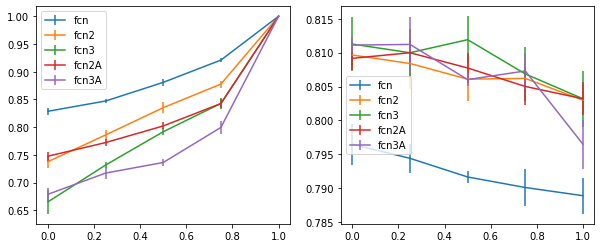

In [15]:
plot_corr_strength(2)

### Model Parameters

In [9]:
# Vbranch params
shared_frac_list = [0., 0.25, 0.5, 0.75, 1.]
num_branches = 2

vbranch_params = []
for frac in shared_frac_list:
    tf.reset_default_graph()
    inputs = tf.placeholder('float32', [None, 32,32,3])
    model = build_model(num_branches, frac)
    model.summary()
    vbranch_params.append(model.count_parameters())

W0801 18:55:04.781267 140469450823424 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/utils/training.py:130: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 18:55:04.802347 140469450823424 deprecation_wrapper.py:119] From /home/gong/research/vbranch/vbranch/utils/training.py:152: The name tf.data.Iterator is deprecated. Please use tf.compat.v1.data.Iterator instead.

W0801 18:55:04.810274 140469450823424 deprecation.py:323] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py:348: Iterator.output_types (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
W0801 18:55:04.812236 140469450823424 deprecation.py:323] From /home/gong/anaconda3/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py:349: Iterator.output_shapes (from tensorflow.pyt

i   Layer name                      Output shape        Num param  Inbound            
--------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                    
--------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                    
--------------------------------------------------------------------------------------
0   conv2d_1_1 (Conv2D)             [] [None,32,32,32]  1792       input              
                                    [] [None,32,32,32]                                
--------------------------------------------------------------------------------------
1   bn_1_1 (BatchNormalization)     [] [None,32,32,32]  128        conv2d_1_1         
                                    [] [None,32,32,32]                                
-------------------------------------------

i   Layer name                      Output shape                     Num param  Inbound            
---------------------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                                 
---------------------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                                 
---------------------------------------------------------------------------------------------------
0   conv2d_1_1 (Conv2D)             [None,32,32,16] [None,32,32,16]  1344       input              
                                    [None,32,32,16] [None,32,32,16]                                
---------------------------------------------------------------------------------------------------
1   bn_1_1 (BatchNormalization)     [None,32,32,16] [None,32,32,16]  96         conv2d_1_1         


i   Layer name                      Output shape        Num param  Inbound            
--------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                    
--------------------------------------------------------------------------------------
    Input                           [None,32,32,3]                                    
--------------------------------------------------------------------------------------
0   conv2d_1_1 (Conv2D)             [None,32,32,32] []  896        input              
                                    [None,32,32,32] []                                
--------------------------------------------------------------------------------------
1   bn_1_1 (BatchNormalization)     [None,32,32,32] []  64         conv2d_1_1         
                                    [None,32,32,32] []                                
-------------------------------------------

In [10]:
param_ratio = [p / vbranch_params[-1] for p in vbranch_params]
ideal_ratio = num_branches - np.array(shared_frac_list)**2 * (num_branches-1)

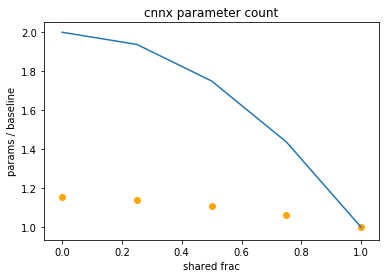

In [11]:
plt.scatter(shared_frac_list, param_ratio, color='orange')
# plt.plot(shared_frac_list, [1]*len(shared_frac_list))
plt.plot(shared_frac_list, ideal_ratio)

plt.xlabel('shared frac')
plt.ylabel('params / baseline')
plt.title('{} parameter count'.format(ARCHITECTURE))

plt.savefig('figs/cnn-small-parameter-count.png')
plt.show()